In [0]:
import csv
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, GlobalAveragePooling2D
from keras.datasets import cifar10, mnist, fashion_mnist
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from utils import StateSpace, Controller


NUM_LAYERS = 4
MAX_TRIALS = 20

EPOCHS = 10
BATCHSIZE = 250
EXPLORATION = 0.9
REGULARIZATION = 1e-2
CONTROLLER_CELLS = 32
EMBEDDING_DIM = 20
ACCURACY_BETA = 0.8
CLIP_REWARDS = 0.0
RESTORE_CONTROLLER = True

policy_sess = tf.Session()
K.set_session(policy_sess)

state_space=StateSpace()
state_space.add_state(name='kernel', values=[1, 3])
state_space.add_state(name='filters', values=[32, 48, 64])
state_space.print_state_space()


(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    print(X_train.shape)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)
dataset = [X_train, y_train, X_test, y_test]
previous_acc = 0.0
total_reward = 0.0

class NetworkManager:
    def __init__(self, dataset, epochs=5, batchsize=128, acc_beta=0.8, clip_rewards=0.0):
        self.dataset = dataset
        self.epochs = epochs
        self.batchsize = batchsize
        self.clip_rewards = clip_rewards

        self.beta = acc_beta
        self.beta_bias = acc_beta
        self.moving_acc = 0.0
    def get_rewards(self, model_fn, actions):
        with tf.Session(graph=tf.Graph()) as network_sess:
            K.set_session(network_sess)
            model = model_fn(actions)
            model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
            X_train, y_train, X_val, y_val = self.dataset
            model.fit(X_train, y_train, batch_size=self.batchsize, epochs=self.epochs,
                      verbose=1, validation_data=(X_val, y_val),
                      callbacks=[ModelCheckpoint('weights/temp_network.h5',
                                                 monitor='val_acc', verbose=1,
                                                 save_best_only=True,
                                                 save_weights_only=True)])
            model.load_weights('weights/temp_network.h5')
            loss, acc = model.evaluate(X_val, y_val, batch_size=self.batchsize)
            reward = (acc - self.moving_acc)
            if self.clip_rewards:
                reward = np.clip(reward, -0.05, 0.05)
            if self.beta > 0.0 and self.beta < 1.0:
                self.moving_acc = self.beta * self.moving_acc + (1 - self.beta) * acc
                self.moving_acc = self.moving_acc / (1 - self.beta_bias)
                self.beta_bias = 0
                reward = np.clip(reward, -0.1, 0.1)
            print()
            print("Manager: EWA Accuracy = ", self.moving_acc)
        network_sess.close()
        return reward, acc


def model_fn(actions):
    kernel_1, filters_1, kernel_2, filters_2, kernel_3, filters_3, kernel_4, filters_4 = actions
    ip = Input(shape=(28, 28, 1))
    x = Conv2D(filters_1, (kernel_1, kernel_1), strides=(2, 2), padding='same', activation='relu')(ip)
    x = Conv2D(filters_2, (kernel_2, kernel_2), strides=(1, 1), padding='same', activation='relu')(x)
    x = Conv2D(filters_3, (kernel_3, kernel_3), strides=(2, 2), padding='same', activation='relu')(x)
    x = Conv2D(filters_4, (kernel_4, kernel_4), strides=(1, 1), padding='same', activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(10, activation='softmax')(x)
    model = Model(ip, x)
    return model

with policy_sess.as_default():
    controller = Controller(policy_sess, NUM_LAYERS, state_space,
                            reg_param=REGULARIZATION,
                            exploration=EXPLORATION,
                            controller_cells=CONTROLLER_CELLS,
                            embedding_dim=EMBEDDING_DIM,
                            restore_controller=RESTORE_CONTROLLER)

manager = NetworkManager(dataset, epochs=EPOCHS, batchsize=BATCHSIZE, clip_rewards=CLIP_REWARDS,
                         acc_beta=ACCURACY_BETA)

state = state_space.get_random_state_space(NUM_LAYERS)
print("Initial Random State : ", state_space.parse_state_space_list(state))
print()

accuracy_plot = []
reward_plot = []
loss_plot = []

for trial in range(MAX_TRIALS):
    with policy_sess.as_default():
        K.set_session(policy_sess)
        actions = controller.get_action(state) 

    state_space.print_actions(actions)
    print("Predicted actions : ", state_space.parse_state_space_list(actions))
    
    reward, previous_acc = manager.get_rewards(model_fn, state_space.parse_state_space_list(actions))
    print("Rewards : ", reward, "Accuracy : ", previous_acc)
   
    with policy_sess.as_default():
        K.set_session(policy_sess)
        temp_action=controller.get_action(state) ## will get the next action; new model
    next_reward, next_acc = manager.get_rewards(model_fn,state_space.parse_state_space_list(temp_action))
    next_reward=0.7*next_reward
    reward+=next_reward
    print("Rewards : ", reward,"Next Reward: ", next_reward, "Accuracy : ", next_acc)
    reward_plot.append(reward)
    
    accuracy_plot.append(next_acc)

    with policy_sess.as_default():
        K.set_session(policy_sess)
        total_reward += reward
        print("Total reward : ", total_reward)
        state = actions
        controller.store_rollout(state, reward)
        loss = controller.train_step()
        loss_plot.append(loss)
        print("Trial %d: Controller loss : %0.6f" % (trial + 1, loss))
        with open('train_history.csv', mode='a+') as f:
            data = [previous_acc, reward]
            data.extend(state_space.parse_state_space_list(state))
            writer = csv.writer(f)
            writer.writerow(data)
    print()
print("Total Reward : ", total_reward)

Using TensorFlow backend.


**************************************** STATE SPACE ****************************************
{ 'id': 0,
  'index_map_': {0: 1, 1: 3},
  'name': 'kernel',
  'size': 2,
  'value_map_': {1: 0, 3: 1},
  'values': [1, 3]}

{ 'id': 1,
  'index_map_': {0: 32, 1: 48, 2: 64},
  'name': 'filters',
  'size': 3,
  'value_map_': {32: 0, 48: 1, 64: 2},
  'values': [32, 48, 64]}



Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.





Instructions for updating:
Call initializer instance with the dtype argument

KeyboardInterrupt: ignored

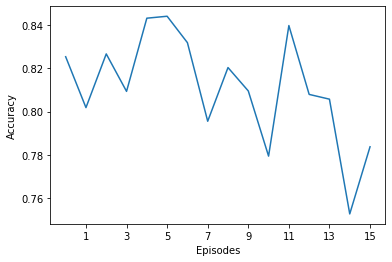

In [0]:
import matplotlib.pyplot as plt
import os

plt.xticks(range(1,20,2))
plt.xlabel('Episodes')
plt.ylabel('Accuracy')
plt.plot(accuracy_plot)
plt.savefig('plots/ac_accuracy.png')

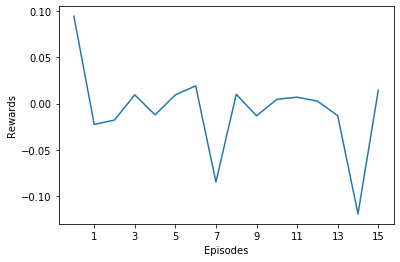

In [0]:
plt.xticks(range(1,20,2))
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.plot(reward_plot)
plt.savefig('plots/ac_reward.png')

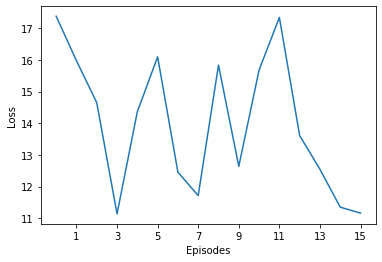

In [0]:
plt.xticks(range(1,20,2))
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.plot(loss_plot)
plt.savefig('plots/ac_loss.png')

In [0]:
np.var(reward_plot)

0.0019968118096116917